In [1]:
%matplotlib inline

In [5]:
import csv
import pandas as pd
import numpy as np
import os
from datetime import datetime
import calendar

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import linregress

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')



In [6]:
# Global declarations
data_path = "..\data"

temp_dataFile = "AvgTempCYear_1.csv"
co2_dataFile = "CO2_GlobalSummary.csv"

#Output folders
result_dir = "..\output"
image_dir = "..\images"

# Plot Style to use
mpl.style.use('seaborn')


# - Month_num to Month Name mapping
month_num = dict((v,k) for k,v in enumerate(calendar.month_abbr))

month_name = list(v for k,v in enumerate(calendar.month_abbr))


### Ready Temperature dataframe to merge with CO2

In [23]:
#read  temp data file
tempDF = pd.read_csv(os.path.join(data_path, temp_dataFile))

# Temporary - Remove once final Temp Data file is ready
if(tempDF.isnull().values.sum() != 0):
    # fill the NA with rowwise means
    rowMeans = tempDF[month_name[1:]].mean(axis = 1)
    tempDF = tempDF.apply(lambda r: r.fillna(rowMeans[r.index]))

# reshape tempDF to have month values in the row
temp_flatDF = pd.melt(tempDF, id_vars =['Country','Year'], var_name = 'Month', value_name = "Monthly_Temp")   

temp_flatDF.head()
 

,Country,Year,Month,Monthly_Temp
0,ALGERIA,1975,Jan,8.9
1,ALGERIA,1976,Jan,8.6
2,ALGERIA,1977,Jan,11.0
3,ALGERIA,1978,Jan,9.1
4,ALGERIA,1979,Jan,13.0


In [24]:
# Group by year and month and aggregate values by mean()

temp_GDF_YM = temp_flatDF.groupby(['Year','Month']).agg(np.mean)

temp_GDF_YM.reset_index(inplace = True)

temp_GDF_YM.head()

,Year,Month,Monthly_Temp
0,1975,Apr,16.607500
1,1975,Aug,20.945000
2,1975,Dec,12.039167
3,1975,Feb,12.323333
4,1975,Jan,12.086667


### Ready CO2 to merge with Temp


In [26]:
#read  temp data file
co2DF = pd.read_csv(os.path.join(data_path, co2_dataFile))

co2DF.rename(columns = {'year' : 'Year'}, inplace = True)

# Temporary - Remove once final Temp Data file is ready
if(co2DF.isnull().values.sum() != 0):
    # fill the NA with rowwise means
    rowMeans = co2DF[month_name[1:]].mean(axis = 1)
    co2DF = co2DF.apply(lambda r: r.fillna(rowMeans[r.index]))

# reshape tempDF to have month values in the row
co2_flatDF = pd.melt(co2DF, id_vars =['Year'], var_name = 'Month', value_name = "Monthly_Co2")   

co2_flatDF.head()

,Year,Month,Monthly_Co2
0,1975,Jan,332.43
1,1976,Jan,332.26
2,1977,Jan,333.94
3,1978,Jan,335.66
4,1979,Jan,337.40


### Merge Temp and Co2 at global level

In [28]:
temp_co2 = pd.merge(temp_GDF_YM, co2_flatDF, left_on = ['Year','Month'], right_on = ['Year','Month'], \
                    how = 'inner', suffixes = ['_temp','_co2'])

temp_co2.head()

,Year,Month,Monthly_Temp,Monthly_Co2
0,1975,Apr,16.607500,332.08
1,1975,Aug,20.945000,328.45
2,1975,Dec,12.039167,332.29
3,1975,Feb,12.323333,332.38
4,1975,Jan,12.086667,332.43


In [36]:
#Add colums to assist in further analysis
 
#Convert month names to month number
temp_co2['Month_Num'] = temp_co2['Month'].apply(lambda r: month_num[r] )

# Add Date column, example 01-Jan-1975
temp_co2['Date'] = temp_co2['Year'].astype(str)+'-'+temp_co2['Month_Num'].astype(str)+'-01'
temp_co2['Date'] = temp_co2['Date'].apply(lambda r: datetime.strptime(r , '%Y-%m-%d'))

#Sort Data Frame by Year and MOnth
temp_co2.sort_values(by = ['Year','Month_Num'])

temp_co2.head()

,Year,Month,Monthly_Temp,Monthly_Co2,Month_Num,Date
0,1975,Apr,16.607500,332.08,4,1975-04-01
1,1975,Aug,20.945000,328.45,8,1975-08-01
2,1975,Dec,12.039167,332.29,12,1975-12-01
3,1975,Feb,12.323333,332.38,2,1975-02-01
4,1975,Jan,12.086667,332.43,1,1975-01-01


## START ANALYSIS

### Use df.corr() to understand correlation between Temp and CO2

In [47]:
temp_co2_GDF = temp_co2[['Year','Monthly_Temp','Monthly_Co2']].groupby('Year').agg(np.mean)
temp_co2_GDF.head()

,Monthly_Temp,Monthly_Co2
Year,,
1975,16.579987,331.180000
1976,16.183403,331.879167
1977,16.635145,333.806667
1978,16.402431,335.386667
1979,16.601778,337.192500


In [48]:
x_axis = temp_co2_GDF['Monthly_Temp']
y_axis = temp_co2_GDF['Monthly_Co2']
np.corrcoef(x_axis, y_axis)

array([[1.        , 0.91877875],
       [0.91877875, 1.        ]])

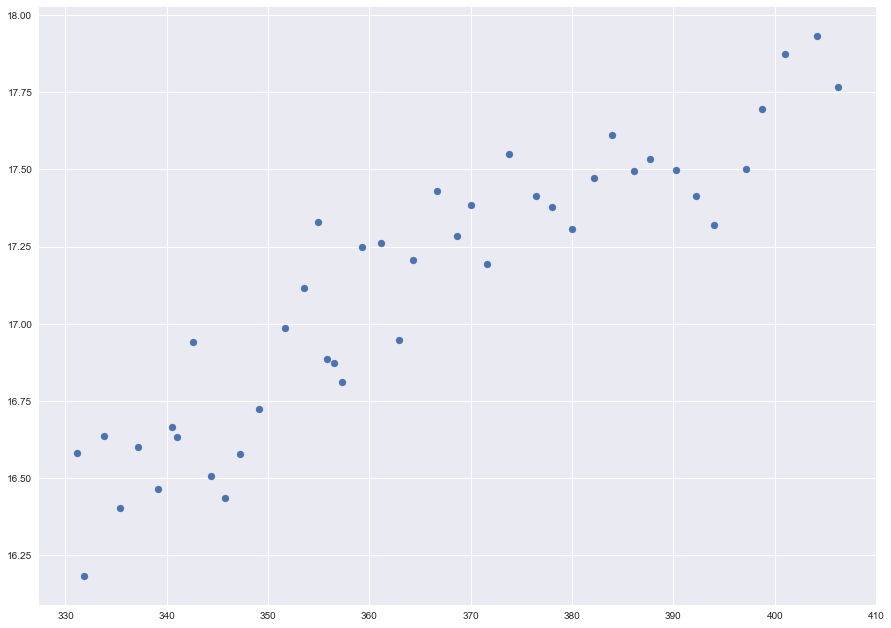

In [49]:
fig, ax = plt.subplots(figsize = (15,11))

ax.scatter('Monthly_Co2','Monthly_Temp', data = temp_co2_GDF )